<a href="https://colab.research.google.com/github/haizznaam/Content-Based-and-Tensorflow-Movie-Recommender-System/blob/main/svd_recommendation_system.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
os.chdir('/content/drive/MyDrive/Movie Recommendation System/The-Movie-Dataset/')
print("We are currently in the folder of ", os.getcwd())

We are currently in the folder of  /content/drive/MyDrive/Movie Recommendation System/The-Movie-Dataset


In this notebook we will first be implamenting SVD, then upgrading it to use regularization and biases and there by turning it into SVD++. From what I understand.

Then we will look at how an algorithem like KNN can be used for movie recomendations by implamenting it and comparing the results to SVD.

Lastly we will try out a more "modern" aproach and implament a beginner NFC algorithem. Which is a neural network algorithem that works in combination with a general matrix factorization algorithem to make predictions. For the matrix factorization we will use our pre trained SVD from the first implamentation that we did.

# Table of Contents

# [SVD](#SVD)
- ## [Data preperation](##Data-preperation)
- ## [Training](##Training)
- ## [Model evaluation](##Model-evaluation)
    - ### [Testing out different k numberd of latent factor values](###Testing-out-different-k-numberd-of-latent-factor-values)
- ## [Upgrading to Tuse Regularization](##Upgrading-to-Tuse-Regularization)
    - ### [Testing out different lambda values paird with different k values](###Testing-out-different-lambda-values-paird-with-different-k-values)
    - ### [Testing out different lambda values paird with different epoch training time/lengths](###Testing-out-different-lambda-values-paird-with-different-epoch-training-time-/-lengths)
- ## [Upgrading to use biases](##Upgrading-to-use-biases)


# [KNN](#KNN)
- ## [Data preperation](##KNN-Data-preperation)
- ## [KNN Implamentation and Training](##KNN-Implamentation-and-Training)
- ## [Implamenting Prediction and Evaluation](##Implamenting-Prediction-and-Evaluation)
- ## [Testing different K values](##Testing-different-K-values)
- ## [Adding new Users or Items or rating and adressing the cold start problem](##Adding-new-Users-or-Items-or-rating-and-adressing-the-cold-start-problem)

# Single Value Decomposition (SVD)

To understand SVD in the fastest time possible pls look at the following youtube links that I have gathered:

*SVD in essance is a mathmatical algorithem and the mathmatical algorithem wasn't developed for recomender systems but for matrix factorization. So I will provide links to the mathmatical backround that really helps understanding what's going on in this implamentation. I wil lalso provide explanation to the theory of SVD as a recomendor system.*

**Pure Mathamtical SVD backround:**

https://www.youtube.com/watch?v=vSczTbgc8Rc

https://www.youtube.com/watch?v=fNk_zzaMoSs

**SVD for recomendation**

https://www.youtube.com/watch?v=E8aMcwmqsTg&t=762s

https://www.youtube.com/watch?v=GGWBMg0i9d4

https://www.youtube.com/watch?v=HY3Csl52PfE&t=222s

## Data preperation

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt
import os
import pickle


In [ ]:
# Load the dataset
df = pd.read_csv('ratings_small.csv')

# Display the first few rows of the dataframe
df.head()


,userId,movieId,rating,timestamp
0,1,31,2.5,1260759144
1,1,1029,3.0,1260759179
2,1,1061,3.0,1260759182
3,1,1129,2.0,1260759185
4,1,1172,4.0,1260759205


In [ ]:
df.columns = ['user_id', 'item_id', 'rating','timestamp']
df.head()

,user_id,item_id,rating,timestamp
0,1,31,2.5,1260759144
1,1,1029,3.0,1260759179
2,1,1061,3.0,1260759182
3,1,1129,2.0,1260759185
4,1,1172,4.0,1260759205


In [ ]:
# Perform a train-test split
train_data, test_data = train_test_split(df, test_size=0.2, random_state=42)

# Check the size of the resulting splits
print(f"Train data size: {train_data.shape}")
print(f"Test data size: {test_data.shape}")

Train data size: (80003, 4)
Test data size: (20001, 4)


The shape of the train set being `(80000, 4)` reflects the tabular format of the MovieLens 100K dataset, where each row represents a single rating event:
- The first number (80000) indicates the total number of individual ratings in the training dataset, derived from performing a train-test split with 20% of the data reserved for testing, leaving 80% for training.
- The second number (4) corresponds to the four columns in the dataset, which are:
  1. `'user_id'`: The ID of the user who made the rating.
  2. `'item_id'`: The ID of the item (movie) that was rated.
  3. `'rating'`: The rating value given by the user to the item.
  4. `'timestamp'`: The time at which the rating was made.

This format is different from the conceptual \(R\) matrix used in recommendation systems, where rows represent users, columns represent items, and entries represent ratings. The tabular format is more compact and practical for storing such data, as the \(R\) matrix would be very sparse (most users haven't rated most items) and inefficient to store directly.


In [ ]:
# Determine the number of unique users and items
num_users = df['user_id'].nunique()
num_items = df['item_id'].nunique()
print("number of unique users:", num_users)
print("number of unique items:", num_items)

# Decide on the number of latent factors
num_factors = 20  # This is the 'k' in your model

# Initialize the user and item latent factor matrices with random values
np.random.seed(42)  # For reproducibility
P = np.random.normal(0, 0.1, (num_users, num_factors))

# Initialize matrix Q with the correct dimensions
max_item_id = max(df['item_id'])
Q = np.random.normal(0, 0.1, (max_item_id, num_factors))

# Print the shapes of the matrices to verify
print(f"Shape of P (User Latent Factors): {P.shape}")
print(f"Shape of Q (Item Latent Factors): {Q.shape}")

number of unique users: 671
number of unique items: 9066
Shape of P (User Latent Factors): (671, 20)
Shape of Q (Item Latent Factors): (163949, 20)


The code block performs the following operations to prepare for implementing an SVD model on the MovieLens 100K dataset:

1. **Determine the Number of Unique Users and Items**:
   - The dataset contains 943 unique users and 1682 unique items (movies). This information is crucial for initializing the latent factor matrices, ensuring they have the correct dimensions to represent all users and items in the dataset.

2. **Decide on the Number of Latent Factors**:
   - A choice of 20 latent factors (`num_factors = 20`) is made for the model. This number determines the dimensionality of the latent space in which user and item interactions are modeled. The selection of 20 as the number of factors is a starting point and can be adjusted based on model performance and computational considerations.

3. **Initialize the User and Item Latent Factor Matrices with Random Values**:
   - The matrices `P` (user latent factors) and `Q` (item latent factors) are initialized with random values drawn from a normal distribution with a mean of 0 and a standard deviation of 0.1. This random initialization serves as a starting point for the gradient descent optimization process.
   - The shapes of `P` and `Q` are `(943, 20)` and `(1682, 20)`, respectively, matching the number of users and items in the dataset and the chosen number of latent factors. This ensures that each user and item is represented in the model.

4. **Reproducibility**:
   - A random seed (`np.random.seed(42)`) is set to ensure that the initialization of `P` and `Q` is reproducible. This is important for debugging and for ensuring consistent results across different runs of the model.

This setup is foundational for building and training the SVD model, providing the necessary parameters and initial conditions to start the optimization process.


In [ ]:
print(f"Train data size: {train_data.shape}")
print(f"Test data size: {test_data.shape}")
print('=' * 50)
print("number of unique users:", num_users)
print("number of unique items:", num_items)
print('=' * 50)
print(f"Shape of P (User Latent Factors): {P.shape}")
print(f"Shape of Q (Item Latent Factors): {Q.shape}")
print('=' * 50)
df.head()

Train data size: (80003, 4)
Test data size: (20001, 4)
number of unique users: 671
number of unique items: 9066
Shape of P (User Latent Factors): (671, 20)
Shape of Q (Item Latent Factors): (163949, 20)


,user_id,item_id,rating,timestamp
0,1,31,2.5,1260759144
1,1,1029,3.0,1260759179
2,1,1061,3.0,1260759182
3,1,1129,2.0,1260759185
4,1,1172,4.0,1260759205


The MovieLens 100K dataset comprises 80,000 training entries, each representing a unique user-item (movie) rating. With 943 unique users and 1682 unique items, the dataset does not follow a "one user, one rating" approach. Instead, it captures a wide range of interactions where individual users have rated multiple movies, and each movie has been rated by multiple users. This structure results in a sparse user-item ratings matrix, where the vast majority of potential user-item combinations are unrated, illustrating the real-world scenario of users interacting with a small subset of available items.

There by the result is that we have 943 unique users, 1682 unique move ratings(items) in a train dataset of 80k movie ratings (a split from the original 100k)

In [ ]:
# Find the minimum user_id in the train and test datasets
min_user_id_train = train_data['user_id'].min()
min_user_id_test = test_data['user_id'].min()

print(f"Minimum user_id in train dataset: {min_user_id_train}")
print(f"Minimum user_id in test dataset: {min_user_id_test}")

# Find the maximum user_id in the train and test datasets
max_user_id_train = train_data['user_id'].max()
max_user_id_test = test_data['user_id'].max()

print(f"Maximum user_id in train dataset: {max_user_id_train}")
print(f"Maximum user_id in test dataset: {max_user_id_test}")

Minimum user_id in train dataset: 1
Minimum user_id in test dataset: 1
Maximum user_id in train dataset: 671
Maximum user_id in test dataset: 671


In [ ]:
# Find the minimum item_id in the train and test datasets
min_item_id_train = train_data['item_id'].min()
min_item_id_test = test_data['item_id'].min()

print(f"Minimum item_id in train dataset: {min_item_id_train}")
print(f"Minimum item_id in test dataset: {min_item_id_test}")

# Find the maximum item_id in the train and test datasets
max_item_id_train = train_data['item_id'].max()
max_item_id_test = test_data['item_id'].max()

print(f"Maximum item_id in train dataset: {max_item_id_train}")
print(f"Maximum item_id in test dataset: {max_item_id_test}")

Minimum item_id in train dataset: 1
Minimum item_id in test dataset: 1
Maximum item_id in train dataset: 163949
Maximum item_id in test dataset: 162672


In [ ]:
train_data.head()

,user_id,item_id,rating,timestamp
37865,273,5816,4.5,1466946328
46342,339,2028,4.5,1446663181
64614,461,3895,0.5,1093224965
41974,300,3578,4.5,1086010878
50236,369,292,3.0,847465462


## Prediction Function

In [ ]:
def predict_rating(user_id, item_id, P, Q):
    """
    Predict the rating of a user for an item.

    Parameters:
    - user_id: The ID of the user.
    - item_id: The ID of the item.
    - P: The matrix of user latent factors.
    - Q: The matrix of item latent factors.

    Returns:
    - The predicted rating for the user-item pair.
    """
    # Convert user_id and item_id to indices for P and Q
    user_idx = user_id - 1  # Assuming user_id starts from 1
    item_idx = item_id - 1  # Assuming item_id starts from 1

    # Calculate the dot product of the user's and item's latent factor vectors
    pred_rating = np.dot(P[user_idx], Q[item_idx])

    return pred_rating

## Loss Function

In [ ]:
def calculate_mse(train_data, P, Q):
    """
    Calculate the Mean Squared Error (MSE) of the prediction.

    Parameters:
    - train_data: The training dataset containing actual user-item ratings.
    - P: The matrix of user latent factors.
    - Q: The matrix of item latent factors.

    Returns:
    - The MSE of the predictions.
    """
    mse = 0.0
    for index, row in train_data.iterrows():
        user_id, item_id, actual_rating = row['user_id'], row['item_id'], row['rating']
        # Convert user_id and item_id to indices
        user_idx = int(user_id) - 1  # Assuming user_id starts from 1
        item_idx = int(item_id) - 1  # Assuming item_id starts from 1
        # Predict rating
        predicted_rating = np.dot(P[user_idx], Q[item_idx])
        # Accumulate the squared error
        mse += (actual_rating - predicted_rating) ** 2
    # Calculate mean
    mse /= len(train_data)
    return mse

In [ ]:
def calculate_rmse(train_data, P, Q):
    """
    Calculate the Mean Squared Error (MSE) of the prediction.

    Parameters:
    - train_data: The training dataset containing actual user-item ratings.
    - P: The matrix of user latent factors.
    - Q: The matrix of item latent factors.

    Returns:
    - The MSE of the predictions.
    """
    mse = 0.0
    for index, row in train_data.iterrows():
        user_id, item_id, actual_rating = row['user_id'], row['item_id'], row['rating']
        # Convert user_id and item_id to indices
        user_idx = user_id - 1  # Assuming user_id starts from 1
        item_idx = item_id - 1  # Assuming item_id starts from 1
        # Predict rating
        predicted_rating = np.dot(P[user_idx], Q[item_idx])
        # Accumulate the squared error
        mse += (actual_rating - predicted_rating) ** 2
    # Calculate mean
    mse /= len(train_data)
    return np.sqrt(mse)

In [ ]:
def calculate_mae(train_data, P, Q):
    """
    Calculate the Mean Absolute Error (MAE) of the prediction.

    Parameters:
    - train_data: The training dataset containing actual user-item ratings.
    - P: The matrix of user latent factors.
    - Q: The matrix of item latent factors.

    Returns:
    - The MAE of the predictions.
    """
    mae = 0.0
    for index, row in train_data.iterrows():
        user_id, item_id, actual_rating = row['user_id'], row['item_id'], row['rating']
        # Convert user_id and item_id to indices
        user_idx = user_id - 1  # Assuming user_id starts from 1
        item_idx = item_id - 1  # Assuming item_id starts from 1
        # Predict rating
        predicted_rating = np.dot(P[user_idx], Q[item_idx])
        # Accumulate the absolute error
        mae += np.abs(actual_rating - predicted_rating)
    # Calculate mean
    mae /= len(train_data)
    return mae

### Prediction and Loss Functions Overview

**Prediction Function**: The `predict_rating` function computes the predicted rating for a given user-item pair. It utilizes the dot product of the user's and item's latent factor vectors from matrices `P` and `Q`. This function is essential for generating predictions based on the current state of the model's parameters.

**Parameters**:
- `user_id`: ID of the user.
- `item_id`: ID of the item.
- `P`: User latent factors matrix.
- `Q`: Item latent factors matrix.

**Returns**: The predicted rating for the user-item pair.

---

**Loss Function**: The `calculate_mse` function calculates the Mean Squared Error (MSE) between actual and predicted ratings for all user-item pairs in the training data. This measure of error is critical for evaluating the model's performance and guiding the optimization process during training.

**Parameters**:
- `train_data`: Training dataset containing actual user-item ratings.
- `P`: User latent factors matrix.
- `Q`: Item latent factors matrix.

**Returns**: The MSE of the predictions across the training dataset.

These functions form the basis for assessing the SVD model's accuracy and guiding the iterative refinement of the model's latent factors through gradient descent.


## Gradient Descent for SVD Optimization


In [ ]:
import numpy as np

def gradient_descent_step(user_id, item_id, actual_rating, P, Q, learning_rate):
    """
    Perform a single gradient descent step and update P and Q.

    Parameters:
    - user_id: The ID of the user.
    - item_id: The ID of the item.
    - actual_rating: The actual rating given by the user to the item.
    - P: The matrix of user latent factors.
    - Q: The matrix of item latent factors.
    - learning_rate: The learning rate for the gradient descent update.

    Returns:
    - Updated P and Q matrices.
    """
    # Convert user_id and item_id to integers for indexing
    user_idx = int(user_id) - 1  # Assuming user_id starts from 1
    item_idx = int(item_id) - 1  # Assuming item_id starts from 1

    # Calculate the prediction error
    pred_rating = np.dot(P[user_idx], Q[item_idx])
    error = actual_rating - pred_rating

    # Calculate the gradients for P and Q
    P_grad = -2 * error * Q[item_idx]
    Q_grad = -2 * error * P[user_idx]

    # Update P and Q
    P[user_idx] -= learning_rate * P_grad
    Q[item_idx] -= learning_rate * Q_grad

    return P, Q


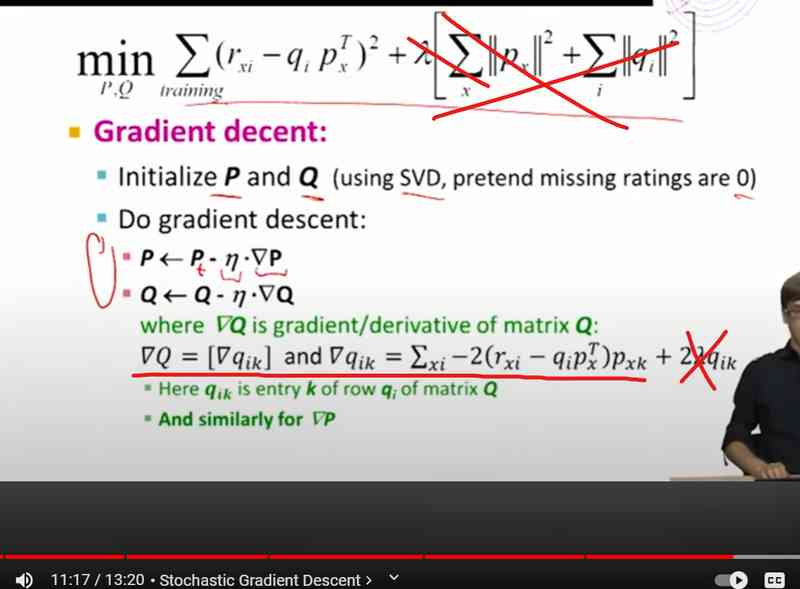

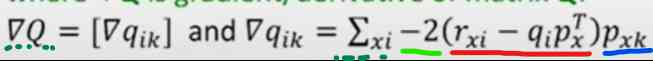

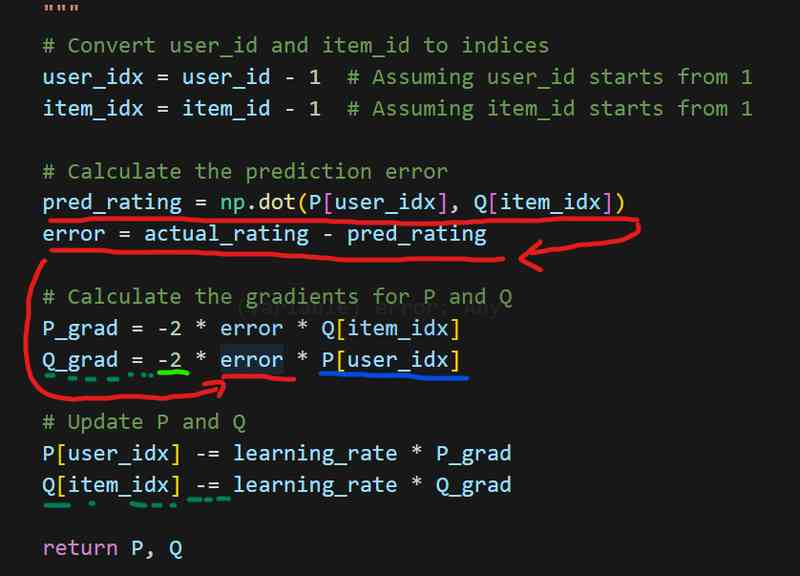

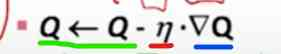

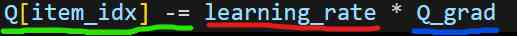

Function to train from the gradient descent function

In [ ]:
def train_model(train_data, P, Q, learning_rate, epochs):
    """
    Train the SVD model using gradient descent.

    Parameters:
    - train_data: The training dataset.
    - P: Initial matrix of user latent factors.
    - Q: Initial matrix of item latent factors.
    - learning_rate: The learning rate for updates.
    - epochs: Number of iterations to train the model.

    Returns:
    - The final, trained P and Q matrices.
    """

    mse_values = []  # Initialize a list to store MSE values

    for epoch in range(epochs):
        for index, row in train_data.iterrows():
            user_id, item_id, actual_rating = row['user_id'], row['item_id'], row['rating']
            P, Q = gradient_descent_step(user_id, item_id, actual_rating, P, Q, learning_rate)

        # Optionally, calculate and print the MSE after each epoch to monitor convergence
        mse = calculate_mse(train_data, P, Q)
        print(f"Epoch {epoch+1}/{epochs}, MSE: {mse}")
        mse_values.append(mse)  # Save the MSE for this epoch

    return P, Q, mse_values

### Gradient Descent Optimization for SVD

**Function: `gradient_descent_step`**
Performs a single step of gradient descent, updating the user and item latent factor matrices (`P` and `Q`) based on their gradients. It calculates the prediction error for a given user-item pair, derives the gradients of the loss function with respect to both `P` and `Q`, and updates these matrices in the direction that minimizes the error.

**Parameters:**
- `user_id`, `item_id`: Identifiers for the user and the item.
- `actual_rating`: The actual rating given by the user to the item.
- `P`, `Q`: User and item latent factor matrices.
- `learning_rate`: The step size for the gradient descent update.

**Returns:**
- Updated `P` and `Q` matrices after a single update step.

---

**Function: `train_model`**
Trains the SVD model over multiple epochs using gradient descent. It iteratively applies `gradient_descent_step` across all ratings in the training dataset, adjusting `P` and `Q` to minimize the overall prediction error. The process is repeated for a specified number of epochs, allowing the model parameters to converge towards optimal values.

**Parameters:**
- `train_data`: The training dataset containing user-item ratings.
- `P`, `Q`: Initial user and item latent factor matrices.
- `learning_rate`: The learning rate for gradient descent updates.
- `epochs`: The number of iterations to run the training process.

**Returns:**
- The trained `P` and `Q` matrices, optimized to predict ratings.

This approach allows for iterative refinement of the model's parameters, leveraging the entire dataset to reduce the mean squared error of predictions. Monitoring the MSE after each epoch provides insights into the training process and convergence behavior.


## Training

## Training Approaches Overview

In the upcoming section, we will explore various training approaches to optimize our Singular Value Decomposition (SVD) model for movie recommendations. Here's what we will cover:

- **Short-Term Training:**
  - **10 Epochs**: We'll start with a quick training run to establish a baseline for how the model performs with minimal epochs.
  - **100 Epochs**: Next, we extend the training duration to observe how the model's performance evolves with more opportunities to learn.

- **Long-Term Training:**
  - **400 Epochs with Static Learning Rate**: We'll significantly increase the number of epochs to push the model towards convergence and see the long-term behavior of the error metrics.

- **Advanced Tracking with Training Episodes:**
  - **Stat Tracking with 400 Epochs (Episode A)**: Utilizing the `TrainingEpisode` class, we'll collect a richer set of statistics during training with a static learning rate, which will help us understand the in-depth training dynamics.

- **Dynamic Learning Rate Implementation:**
  - **Dynamic Learning Rate with 400 Epochs (Episode B)**: We'll implement a dynamic learning rate that decays over time to see if we can achieve a more efficient convergence by taking larger steps initially and then fine-tuning the model with smaller adjustments.

- **Exploring Learning Rate Effects:**
  - **High Static Learning Rate with 400 Epochs (Episode C)**: To demonstrate the impact of learning rate choice, we'll intentionally set a high learning rate throughout the training process to observe the potential consequences of overshooting the minimum error.

By comparing these different strategies, we aim to identify best practices for training our SVD model and to understand the influence of epoch count and learning rate on the training process and model performance.


In [ ]:
# Set the learning rate and number of epochs
learning_rate = 0.01  # This is a commonly chosen starting value
epochs = 10  # The number of iterations to train the model

# Call the train_model function with the specified parameters
P_trained, Q_trained, mse_values = train_model(train_data, P, Q, learning_rate, epochs)

Epoch 1/10, MSE: 3.412412710588881
Epoch 2/10, MSE: 1.2532690040330219
Epoch 3/10, MSE: 0.8326136610418776
Epoch 4/10, MSE: 0.6505798172502741
Epoch 5/10, MSE: 0.5431344011571971
Epoch 6/10, MSE: 0.4701764380916966
Epoch 7/10, MSE: 0.41683800424941964
Epoch 8/10, MSE: 0.37620733665842104
Epoch 9/10, MSE: 0.34427184384936854
Epoch 10/10, MSE: 0.3184856563359017


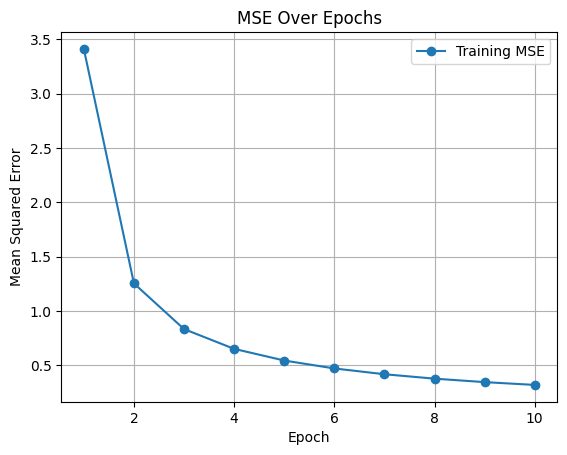

In [ ]:
# Now, plot the MSE values
plt.plot(range(1, epochs+1), mse_values, marker='o', label='Training MSE')
plt.title('MSE Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Mean Squared Error')
plt.legend()
plt.grid(True)
plt.show()

#### Training MSE Over 100 Epochs
- Rapid decrease in MSE, indicating significant learning.
- Steepest improvements are in the earliest epochs.
- Suggests potential for further reduction in error with more epochs.


In [ ]:
# Set the learning rate and number of epochs
learning_rate = 0.01  # This is a commonly chosen starting value
epochs = 100  # The number of iterations to train the model

# Call the train_model function with the specified parameters
P_trained_A, Q_trained_A, mse_values = train_model(train_data, P, Q, learning_rate, epochs)

Epoch 1/100, MSE: 0.29722038345758567
Epoch 2/100, MSE: 0.27941307485087896
Epoch 3/100, MSE: 0.26432821797662837
Epoch 4/100, MSE: 0.2514260496242012
Epoch 5/100, MSE: 0.24029566867699545
Epoch 6/100, MSE: 0.230618018555041
Epoch 7/100, MSE: 0.22214214677654603
Epoch 8/100, MSE: 0.21466836638092107
Epoch 9/100, MSE: 0.20803593807748116
Epoch 10/100, MSE: 0.2021141198126638
Epoch 11/100, MSE: 0.19679571124707917
Epoch 12/100, MSE: 0.19199234157433148
Epoch 13/100, MSE: 0.18763091824449088
Epoch 14/100, MSE: 0.18365084456518976
Epoch 15/100, MSE: 0.1800017706106901
Epoch 16/100, MSE: 0.17664174396628696
Epoch 17/100, MSE: 0.1735356822787278
Epoch 18/100, MSE: 0.170654115317045
Epoch 19/100, MSE: 0.16797215506476212
Epoch 20/100, MSE: 0.1654686574983018
Epoch 21/100, MSE: 0.16312554354884481
Epoch 22/100, MSE: 0.1609272507180467
Epoch 23/100, MSE: 0.15886029098588914
Epoch 24/100, MSE: 0.1569128946882033
Epoch 25/100, MSE: 0.1550747236716486
Epoch 26/100, MSE: 0.15333664012884787
Epoch 2

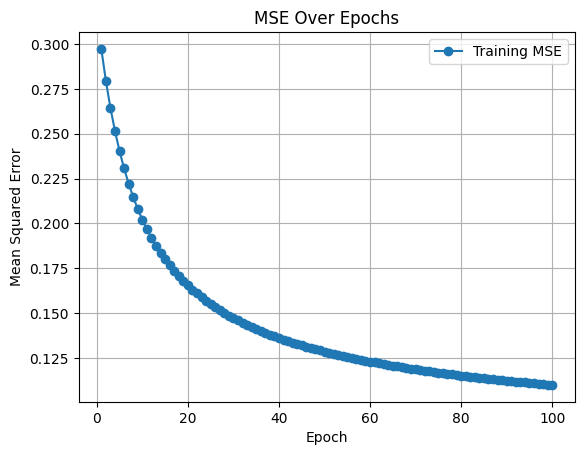

In [ ]:
# Now, plot the MSE values
plt.plot(range(1, epochs+1), mse_values, marker='o', label='Training MSE')
plt.title('MSE Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Mean Squared Error')
plt.legend()
plt.grid(True)
plt.show()

#### Training MSE Over 400 Epochs
- Consistent decline in MSE, showing continued learning over time.
- The rate of decrease slows, indicating diminishing returns on additional epochs.
- Training still appears to be beneficial and has not yet plateaued.


In [ ]:
# Set the learning rate and number of epochs
learning_rate = 0.01  # This is a commonly chosen starting value
epochs = 400  # The number of iterations to train the model

# Call the train_model function with the specified parameters
P_trained_B, Q_trained_B, mse_values = train_model(train_data, P, Q, learning_rate, epochs)

Epoch 1/400, MSE: 0.10975139944211994
Epoch 2/400, MSE: 0.109537321227464
Epoch 3/400, MSE: 0.10932650351370089
Epoch 4/400, MSE: 0.10911886132516102
Epoch 5/400, MSE: 0.10891431262914737
Epoch 6/400, MSE: 0.10871277823263088
Epoch 7/400, MSE: 0.1085141816819597
Epoch 8/400, MSE: 0.10831844916544453
Epoch 9/400, MSE: 0.10812550941872788
Epoch 10/400, MSE: 0.1079352936327816
Epoch 11/400, MSE: 0.10774773536451479
Epoch 12/400, MSE: 0.10756277044986436
Epoch 13/400, MSE: 0.10738033691934663
Epoch 14/400, MSE: 0.1072003749160317
Epoch 15/400, MSE: 0.10702282661585842
Epoch 16/400, MSE: 0.1068476361502925
Epoch 17/400, MSE: 0.10667474953127895
Epoch 18/400, MSE: 0.10650411457847236
Epoch 19/400, MSE: 0.10633568084869378
Epoch 20/400, MSE: 0.10616939956761601
Epoch 21/400, MSE: 0.1060052235636274
Epoch 22/400, MSE: 0.10584310720387119
Epoch 23/400, MSE: 0.10568300633240585
Epoch 24/400, MSE: 0.105524878210492
Epoch 25/400, MSE: 0.10536868145893988
Epoch 26/400, MSE: 0.10521437600252664
Epoc

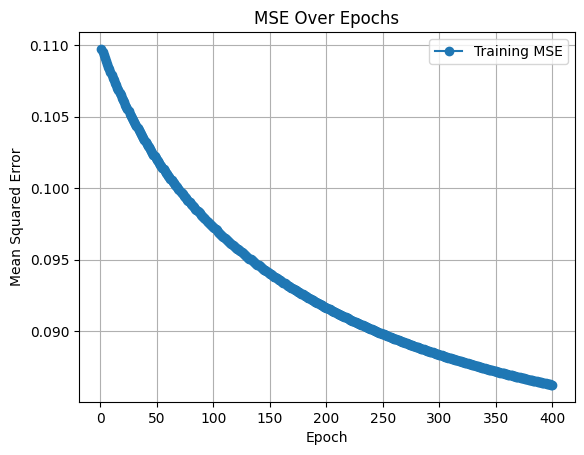

In [ ]:
# Now, plot the MSE values
plt.plot(range(1, epochs+1), mse_values, marker='o', label='Training MSE')
plt.title('MSE Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Mean Squared Error')
plt.legend()
plt.grid(True)
plt.show()

#### Training MSE Over 400 Epochs
- Gradual decrease in MSE, with diminishing improvements as epochs increase.
- The flattening curve suggests approaching an asymptote, close to convergence.
- Indicates that further training may yield very minor improvements, signaling a good point to consider stopping.


### Advanced Training Approach: Training Episodes and Dynamic Learning Rates

We are now transitioning from our initial simple training function to an enhanced version that utilizes the `TrainingEpisode` class. This upgrade will not only streamline the training process but also allow us to gather a richer set of statistics during training, providing deeper insights into our model's performance and behavior.

#### Tracked Statistics:
- **MSE Values**: We track the Mean Squared Error at each epoch to monitor the model's prediction accuracy over time.
- **Gradient Magnitudes**: By recording the magnitude of the gradients, we can observe how our model's updates evolve, which helps in understanding the learning dynamics.
- **Latent Factor Matrices (P and Q) Over Epochs**: Storing the snapshots of these matrices over epochs allows us to analyze the stability and convergence of the model's parameters.
- **Differences**: The change in MSE from one epoch to the next gives us an immediate sense of model improvement rate, indicating when the model may be plateauing.
- **Learning Rate**: Although not utilized in the upcoming training session, the dynamic learning rate system is implemented for future use.

#### Dynamic Learning Rate System:
The `LearningRateScheduler` class introduces a dynamic learning rate system, which adjusts the learning rate as training progresses. This is beneficial for several reasons:
- **Avoids Overshooting**: Prevents the learning rate from being too high and skipping over minima.
- **Refines Learning**: As the model approaches optimal parameters, smaller learning rates allow for more precise updates.
- **Adapts Over Time**: Automatically decreases the learning rate, helping the model to converge as it learns.

For the upcoming training session, we will retain a constant learning rate to benchmark the new tracking functionalities against our previous 400-epoch training. We aim to collect detailed statistics that were not captured previously. Following this, we will activate the dynamic learning rate in the subsequent training episode to fully leverage the potential of our enhanced training system.


#### Distribution of P and Q Values
The distribution of the final P and Q values approximates a Gaussian distribution. While this outcome may not be directly informative for our recommendation system, it confirms that the latent factors' values are well-distributed and do not exhibit any unexpected skewness or bias. This graph is retained for the sake of completeness and could potentially be of interest for a deeper statistical analysis of the latent factor distributions.


<ipython-input-37-139d5aeabdfb>:6: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(P_trained_A.flatten(), fit=norm, kde=False, label='P Values')
<ipython-input-37-139d5aeabdfb>:7: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(Q_trained_A.flatten(), fit=norm, kde=False, label='Q Values')


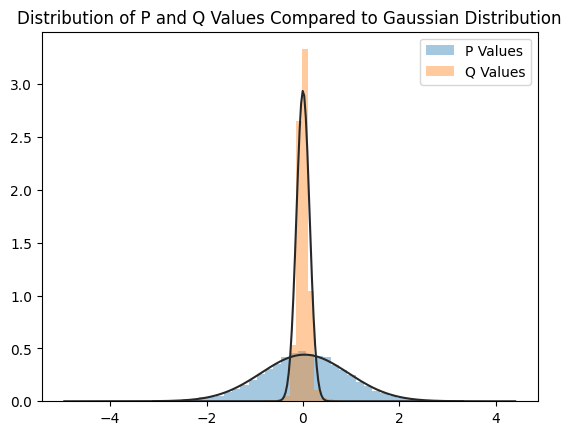

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import norm

# Assuming you have the final P and Q matrices
sns.distplot(P_trained_A.flatten(), fit=norm, kde=False, label='P Values')
sns.distplot(Q_trained_A.flatten(), fit=norm, kde=False, label='Q Values')
plt.title('Distribution of P and Q Values Compared to Gaussian Distribution')
plt.legend()
plt.show()

### Training summary

Below is a bullet-form summary of all the training attempts and episodes covered in this section:

- **Initial Training Attempts:**
  - **10 Epochs**: A short training run to establish a baseline for model performance.
  - **100 Epochs**: An extended training session to observe the progression of learning over a longer period.
  - **400 Epochs with Static Learning Rate**: A further extended training to evaluate the model's performance and potential for convergence over many epochs.


## Model evaluation

In [ ]:
def predict(user_id, item_id, P, Q):
    """
    Predict the rating of a user for an item using the dot product of P and Q.
    """
    # Convert user_id and item_id to indices
    user_idx = user_id - 1  # Adjusting index if user_id/item_id starts from 1
    item_idx = item_id - 1

    # Dot product of user and item factors to get the predicted rating
    rating_pred = np.dot(P[user_idx, :], Q[item_idx, :])
    return rating_pred


In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
from math import sqrt

def evaluate_model(dataset, P, Q):
    """
    Evaluate the model's performance on the given dataset.
    """
    predictions = []
    actuals = []

    for index, row in dataset.iterrows():
        user_id, item_id, actual_rating = row['user_id'].astype('int'), row['item_id'].astype('int'), row['rating']
        predicted_rating = predict(user_id, item_id, P, Q)
        predictions.append(predicted_rating)
        actuals.append(actual_rating)

    # Calculate RMSE and MAE
    rmse = sqrt(mean_squared_error(actuals, predictions))
    mae = mean_absolute_error(actuals, predictions)
    return rmse, mae


In [ ]:
print('Epochs 400')
print("=" * 50)

train_rmse, train_mae = evaluate_model(train_data, P_trained_B, Q_trained_B)
print(f"Training Data - RMSE: {train_rmse}, MAE: {train_mae}")

test_rmse, test_mae = evaluate_model(test_data, P_trained_B, Q_trained_B)
print(f"Testing Data - RMSE: {test_rmse}, MAE: {test_mae}")

Epochs 400
Training Data - RMSE: 0.2936277979012646, MAE: 0.1885700095951858
Testing Data - RMSE: 1.7387834579473243, MAE: 1.2420709512325747


In [ ]:
print('Epochs 100')
print("=" * 50)

train_rmse, train_mae = evaluate_model(train_data, P_trained_A, Q_trained_A)
print(f"Training Data - RMSE: {train_rmse}, MAE: {train_mae}")

test_rmse, test_mae = evaluate_model(test_data, P_trained_A, Q_trained_A)
print(f"Testing Data - RMSE: {test_rmse}, MAE: {test_mae}")

Epochs 100
Training Data - RMSE: 0.2936277979012646, MAE: 0.1885700095951858
Testing Data - RMSE: 1.7387834579473243, MAE: 1.2420709512325747


As we can see above our model has a bigger error on the unseen training data which is normal. It could means our model hasn't generalized well yet. It could also mean our model overfit the trainign data but I don't think that is the case here since we can still do more training.

# SVD ++

In this notebook we will first be implamenting SVD, then upgrading it to use regularization and biases and there by turning it into SVD++. From what I understand.

Certainly! In the context of matrix factorization techniques for recommender systems, incorporating biases into SVD (often referred to as SVD++) allows the model to account for the inherent biases associated with both users and items. This means accounting for the fact that some users may generally give higher or lower ratings than others (user bias), and some items may generally receive higher or lower ratings than others (item bias), regardless of the interaction between specific users and items.

### Mathematical Formulation

The prediction $\hat{r}_{ui}$ for a user $u$ and item $i$ in SVD with biases can be formulated as:
$$\large \hat{r}_{ui} = \mu + b_u + b_i + q_i^Tp_u$$

where:
- $\hat{r}_{ui}$: is the predicted rating of user $u$ for item $i$.

- $\mu$ is the global average rating across all users and items.

- $b_u$ is the bias associated with user $u$.

- $b_i$ is the bias associated with item $i$.

- $q_i$ is the latent factor vector for item $i$.

- $p_u$ is the laten factor vector for user $u$.

### Regularization in SVD with Biases

When incorporating regularization, the cost function is extended to penalize the magnitude of the bias terms in addition to the latent factors. The regularized cost function becomes:

$$\large J = \sum_{(u,i) \in \kappa} (r_{ui} - \hat{r}_{ui})^2 + \lambda(\|p_u\|^2 + \|q_i\|^2 + b_u^2 + b_i^2) $$

where:

- $κ$: is the set of all user-items pairs for which the rating is known

- $λ$ is the regularization parameter that controls the extent of regularization

- The term $\|p_u\|^2, \|q_i\|^2, b_u^2,$ and $b_i^2$ represent the $L2$ norm of the user and item latent factors and the squares of the user and item biases, repspectively.

## Gradient Descent Update Rules with Regularization for Biases

The gradient descent update rules for the biases and latent factors with regularization are:
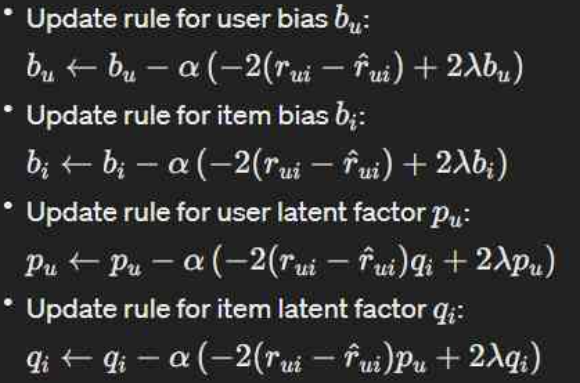

Here, $\alpha$ is the learning rate, which controls the step size of the updates.

Incorporating user and item biases into SVD can significantly improve the accuracy of the recommendations by capturing the overall tendencies of users and items, while regularization helps to prevent overfitting by penalizing overly complex models.


So first we need to change all of our previous functions ot now include biases

Lets update the function that calculates the error

In [ ]:
def calculate_mse_with_biases(train_data, P, Q, b_u, b_i, mu):
    mse = 0.0
    for index, row in train_data.iterrows():
        user_id, item_id, actual_rating = row['user_id'].astype(int), row['item_id'].astype(int), row['rating']
        user_idx = user_id - 1
        item_idx = item_id - 1
        predicted_rating = mu + b_u[user_idx] + b_i[item_idx] + np.dot(P[user_idx], Q[item_idx])
        mse += (actual_rating - predicted_rating) ** 2
    mse /= len(train_data)
    return mse


Lets update the function that predicts values

In [ ]:
def predict(user_id, item_id, P, Q, b_u, b_i, mu):
    user_idx = int(user_id) - 1
    item_idx = int(item_id) - 1
    rating_pred = mu + b_u[user_idx] + b_i[item_idx] + np.dot(P[user_idx], Q[item_idx])
    return rating_pred

Lets update the function that evalutes the "model"

In [ ]:
def evaluate_model(dataset, P, Q, b_u, b_i, mu):
    predictions = []
    actuals = []

    for index, row in dataset.iterrows():
        user_id, item_id, actual_rating = row['user_id'].astype(int), row['item_id'].astype(int), row['rating']
        predicted_rating = predict(user_id, item_id, P, Q, b_u, b_i, mu)
        predictions.append(predicted_rating)
        actuals.append(actual_rating)

    rmse = sqrt(mean_squared_error(actuals, predictions))
    mae = mean_absolute_error(actuals, predictions)
    return rmse, mae


In [ ]:
class LearningRateScheduler:
    def __init__(self, initial_lr=0.01, min_lr=0.001, decay=0.5, epochs_drop=10):
        self.initial_lr = initial_lr
        self.min_lr = min_lr
        self.decay = decay
        self.epochs_drop = epochs_drop
        self.lr = initial_lr

    def get_lr(self, epoch):
        """Calculate the learning rate for a given epoch."""
        new_lr = self.initial_lr * (self.decay ** np.floor((1+epoch)/self.epochs_drop))
        # Ensure the learning rate never falls below the minimum specified
        self.lr = max(new_lr, self.min_lr)
        return self.lr

    def reset(self):
        """Reset the learning rate to its initial value."""
        self.lr = self.initial_lr


Lets update the episode and stats tracking class

In [ ]:
import os
import pickle

class TrainingEpisode:
    def __init__(self, name):
        self.name = name
        self.mse_values = []
        self.gradient_magnitudes = []
        self.P_all_epochs = []
        self.Q_all_epochs = []
        self.b_u_all_epochs = []  # Store user biases for each epoch
        self.b_i_all_epochs = []  # Store item biases for each epoch
        self.differences = []

    def update(self, P, Q, b_u, b_i, mse, gradient_magnitude, difference):
        self.P_all_epochs.append(P.copy())
        self.Q_all_epochs.append(Q.copy())
        self.b_u_all_epochs.append(b_u.copy())  # Append user biases
        self.b_i_all_epochs.append(b_i.copy())  # Append item biases
        self.mse_values.append(mse)
        self.gradient_magnitudes.append(gradient_magnitude)
        self.differences.append(difference)

    def last_epoch(self):
        return len(self.mse_values)

    def save(self, path='./'):
        # Create the directory if it doesn't exist
        os.makedirs(path, exist_ok=True)
        filepath = os.path.join(path, f"{self.name}.pkl")
        with open(filepath, 'wb') as file:
            pickle.dump(self, file)
        print(f"TrainingEpisode '{self.name}' saved to {filepath}")

    @staticmethod
    def load(name, path='./'):
        filepath = os.path.join(path, f"{name}.pkl")
        if os.path.exists(filepath):
            with open(filepath, 'rb') as file:
                episode = pickle.load(file)
            print(f"TrainingEpisode '{name}' loaded from {filepath}")
            return episode
        else:
            print(f"File {filepath} does not exist.")
            return None


And finally lets update the training function

In [ ]:
import numpy as np

def train_model_with_episode(train_data, P, Q, epochs, episode, lr_scheduler, lambda_reg, b_u, b_i, mu, track_index=0, auto_save=True, auto_save_every_n=10):
    num_users = P.shape[0]
    num_items = Q.shape[0]

    for epoch in range(episode.last_epoch(), epochs):
        learning_rate = lr_scheduler.get_lr(epoch)
        gradient_magnitude = []

        for index, row in train_data.iterrows():
            user_id, item_id, actual_rating = row['user_id'].astype(int), row['item_id'].astype(int), row['rating']
            user_idx = user_id - 1  # Adjust index if necessary
            item_idx = item_id - 1

            # Predict rating with biases
            pred_rating = mu + b_u[user_idx] + b_i[item_idx] + np.dot(P[user_idx], Q[item_idx])
            error = actual_rating - pred_rating

            # Update gradients for P, Q, b_u, and b_i
            P_grad = -2 * error * Q[item_idx] + 2 * lambda_reg * P[user_idx]
            Q_grad = -2 * error * P[user_idx] + 2 * lambda_reg * Q[item_idx]
            b_u_grad = -2 * error + 2 * lambda_reg * b_u[user_idx]
            b_i_grad = -2 * error + 2 * lambda_reg * b_i[item_idx]

            # Update P, Q, b_u, and b_i
            P[user_idx] -= learning_rate * P_grad
            Q[item_idx] -= learning_rate * Q_grad
            b_u[user_idx] -= learning_rate * b_u_grad
            b_i[item_idx] -= learning_rate * b_i_grad

            # Store the gradient magnitude for the tracked index (optional, adjust as needed)
            gradient_magnitude.append(np.linalg.norm(P_grad) + np.linalg.norm(Q_grad))

        # Optional: Calculate and update MSE and difference for this epoch, including biases in prediction
        mse = calculate_mse_with_biases(train_data, P, Q, b_u, b_i, mu)  # You'll need to implement this function
        difference = episode.mse_values[-1] - mse if episode.mse_values else 0
        episode.update(P, Q, b_u, b_i, mse, gradient_magnitude, difference)  # Adjust 'update' method if necessary

        print(f"Epoch {epoch+1}/{epochs}, MSE: {mse}, Difference: {difference}, Learning Rate: {learning_rate}")
        if epoch % auto_save_every_n == 0 and auto_save:
            episode.save("auto_saves")

    return P, Q, b_u, b_i

# Note: You need to implement calculate_mse_with_biases to include biases in the MSE calculation.
# Also, adjust the 'update' method of the 'TrainingEpisode' class if necessary to handle biases.


ANd now lasst and finally for SVD lets train and test our full model with the best hyperparameters that we determained through various tests and data visualizations including the new biases in our model

In [ ]:
max_item_id = max(df['item_id'])
max_item_id

163949

In [ ]:
# Initialize global bias (mu)
mu = train_data['rating'].mean()

max_item_id = max(df['item_id'])

# Initialize user and item biases
b_u = np.zeros(num_users)
b_i = np.zeros(max_item_id)

# Set up the training episode
episode_name = "training_400_epochs_biased_lambda_0.1"
episode = TrainingEpisode(episode_name)

start_P = np.random.normal(0, 0.1, (num_users, num_factors))
start_Q = np.random.normal(0, 0.1, (max_item_id, num_factors))

# Learning rate scheduler
lr_scheduler = LearningRateScheduler(initial_lr=0.03, min_lr=0.0001, decay=0.99, epochs_drop=1)

# Train the model
trained_P, trained_Q, b_u, b_i = train_model_with_episode(train_data, start_P, start_Q, 400, episode, lr_scheduler, lambda_reg=0.1, b_u=b_u, b_i=b_i, mu=mu)

# Save the final state
episode.save()

Epoch 1/400, MSE: 0.7591960121226363, Difference: 0, Learning Rate: 0.029699999999999997
TrainingEpisode 'training_400_epochs_biased_lambda_0.1' saved to auto_saves/training_400_epochs_biased_lambda_0.1.pkl
Epoch 2/400, MSE: 0.7215898712591263, Difference: 0.037606140863509996, Learning Rate: 0.029403
Epoch 3/400, MSE: 0.6946654233662958, Difference: 0.02692444789283055, Learning Rate: 0.029108969999999998
Epoch 4/400, MSE: 0.6658876417520336, Difference: 0.028777781614262143, Learning Rate: 0.028817880299999998
Epoch 5/400, MSE: 0.6308775143114058, Difference: 0.035010127440627814, Learning Rate: 0.028529701496999998
Epoch 6/400, MSE: 0.5903289346893508, Difference: 0.04054857962205505, Learning Rate: 0.02824440448203
Epoch 7/400, MSE: 0.5488547759712823, Difference: 0.04147415871806848, Learning Rate: 0.027961960437209697
Epoch 8/400, MSE: 0.5106701542574473, Difference: 0.038184621713834965, Learning Rate: 0.0276823408328376
Epoch 9/400, MSE: 0.4775552538489537, Difference: 0.033114

In [ ]:
# Now, plot the MSE values
plt.plot(range(1, len(episode.mse_values)+1), episode.mse_values, marker='o', label='Training MSE')
plt.title('MSE Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Mean Squared Error')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
# Assuming episode_B is your TrainingEpisode instance from which you can retrieve P and Q
P_trained = episode.P_all_epochs[-1]  # The last epoch's P matrix
Q_trained = episode.Q_all_epochs[-1]  # The last epoch's Q matrix

print("SVD++")
print("="*50)
# Evaluate on training data
train_rmse, train_mae = evaluate_model(train_data, trained_P, trained_Q, b_u, b_i, mu)
print(f"Training Data - RMSE: {train_rmse}, MAE: {train_mae}")

# Evaluate on test data
test_rmse, test_mae = evaluate_model(test_data, trained_P, trained_Q, b_u, b_i, mu)
print(f"Test Data - RMSE: {test_rmse}, MAE: {test_mae}")


It seems that the training error is bigger then without regularization on training episode B but because of regularization and bias for individual users and movies we get a lower error on the unseen test data RMSE 0.9 which is quite better then the 1.4 rmse on unseen data that we hade without hyper parameter tuning, corssvaldiation and implamantations of regularization and biases

In [ ]:
import numpy as np
from scipy.sparse.linalg import svds

def initialize_p_q_via_svd(train_data, num_users, num_items, num_factors):
    # Step 1: Create the ratings matrix and fill in the missing values
    ratings_matrix = np.full((num_users, num_items), np.nan)
    for index, row in train_data.iterrows():
        user_idx = int(row['user_id']) - 1  # Adjust if user_id starts from 1
        item_idx = int(row['item_id']) - 1  # Adjust if item_id starts from 1
        ratings_matrix[user_idx, item_idx] = row['rating']

    # Fill in the missing values with the global average rating
    global_average = np.nanmean(ratings_matrix)
    ratings_matrix = np.nan_to_num(ratings_matrix, nan=global_average)

    # Step 2: Perform SVD
    U, sigma, Vt = svds(ratings_matrix, k=num_factors)
    sigma = np.diag(sigma)

    # Step 3: Multiply U and Vt by the square root of sigma
    P = np.dot(U, np.sqrt(sigma))
    Q = np.dot(np.sqrt(sigma), Vt).T  # .T to make it align with our Q dimensions

    return P, Q

In [ ]:
# Initialize global bias (mu)
mu = train_data['rating'].mean()

# Initialize user and item biases
b_u = np.zeros(num_users)
b_i = np.zeros(max_item_id)

# Set up the training episode
episode_name = "training_400_epochs_biased_lambda_0.1_sparse_init"
episode = TrainingEpisode(episode_name)
num_factors = 180
sparse_P, sparse_Q = initialize_p_q_via_svd(train_data, num_users, num_items, num_factors)
# Learning rate scheduler
lr_scheduler = LearningRateScheduler(initial_lr=0.03, min_lr=0.0001, decay=0.99, epochs_drop=1)

# Train the model
trained_P_sparse, trained_Q_sparse, b_u_sparse, b_i_sparse = train_model_with_episode(train_data, sparse_P, sparse_Q, 400, episode, lr_scheduler, lambda_reg=0.1, b_u=b_u, b_i=b_i, mu=mu)

# Save the final state
episode.save()